In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import torch
import zarr
from sklearn.metrics import confusion_matrix

import cbh_data_definitions
import cbh_torch_lstm  # defined in directory (model definition)

## Define the evaluation data

In [2]:
root_data_directory = pathlib.Path(os.environ["SCRATCH"]) / "cbh_data"
test_data_path = (
    root_data_directory / "analysis_ready" / "dev.zarr"
)  # must change with available test data

In [3]:
test_input, test_labels, test_cloud_volume = cbh_data_definitions.load_data_from_zarr(
    test_data_path
)
print(test_labels.chunksize[0])
print(len(test_labels))

Loaded zarr, file information:
 Name        : /
Type        : zarr.hierarchy.Group
Read-only   : False
Store type  : zarr.storage.DirectoryStore
No. members : 3
No. arrays  : 3
No. groups  : 0
Arrays      : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
            : humidity_temp_pressure_x.zarr
 

102400
307200


In [4]:
collate_fn = cbh_data_definitions.dataloader_collate_with_dask
batch_size = int(test_labels.chunksize[0] / 4)
workers_on_system = 0
test_dataloader = cbh_data_definitions.define_data_get_loader(
    test_input,
    test_cloud_volume,
    test_labels,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers_on_system,
    collate_fn=collate_fn,
)

## Define the network

In [5]:
checkpoint_path = "./model_out_2022-10-04 14:26:45.061497.ckpt"

In [6]:
LSTM = True
MLP = False
if LSTM:
    model = cbh_torch_lstm.CloudBaseLSTM.load_from_checkpoint(checkpoint_path)
    model.eval()
if MLP:
    ...

## Get model predictions for Eval

In [7]:
%%time
all_preds = np.empty(0)
all_targs = np.empty(0)
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch["cloud_base_target"]), axis=0)
    height = sample_batch["height_vector"]
    x = sample_batch["x"]
    batch_preds, _ = model(x, height)  # self call = forward
    class_prediction = np.argmax(batch_preds.detach().numpy(), axis=1)
    all_preds = np.concatenate(
        (all_preds, class_prediction), axis=0
    )  # get second value only (since model doesn't support the other return per how it is currently defined)

print("Length of prediction output:", all_preds.shape)
print("Prediction output matches target output:", all_targs.shape == all_preds.shape)

Length of prediction output: (307200,)
Prediction output matches target output: True
CPU times: user 9min 42s, sys: 38.8 s, total: 10min 20s
Wall time: 9min 14s


In [8]:
print("Show of some predictions :", all_preds[0:20])
print("Show of some targets, same samples:", all_targs[0:20])
print(
    "Model predictions binned: (Class labels), (Counts):",
    np.unique(all_preds, return_counts=True),
)
print(
    "Target labels binned: (Class labels), (Counts):",
    np.unique(all_targs, return_counts=True),
)
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))

Show of some predictions : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Show of some targets, same samples: [16. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16.]
Model predictions binned: (Class labels), (Counts): (array([ 0., 69.]), array([101368, 205832]))
Target labels binned: (Class labels), (Counts): (array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       69.]), array([48207,  7345,  6824,  6581,  6311,  5855,  6811,  8105,  8406,
        7745,  8055,  8211,  7782,  7082,  5604,  4535,  4367,  3159,
        2949,  2475,  2263,  2132,  2052,  2493,  3018,  4325,  3172,
        2532,  2182,  2454,  2408,  2293,  2251,  2644,  3003,  3200,
        3398,  3574,  3818,  3882,  2967,  2353,  1856,  1379,  

## Evaluate model returns

In [9]:
def old_cbh_eval(preds, targs):
    # for all tested height layers
    abcd_list = []
    for k in np.arange(0, 53, 1):
        a = 0.0
        b = 0.0
        c = 0.0
        d = 0.0
        for i in np.arange(0, targs.shape[1]):
            # Is the cloud-base at this level or below.
            if targs[0, i] <= np.float64(k) and preds[0, i] <= np.float64(k):
                # Hit
                a = a + 1.0
            elif targs[0, i] > np.float64(k) and preds[0, i] <= np.float64(k):
                # False alarm
                b = b + 1.0
            elif targs[0, i] <= np.float64(k) and preds[0, i] > np.float64(k):
                # Miss
                c = c + 1.0
            else:
                # Correct negative
                d = d + 1.0
        if a == 0.0 or b == 0.0:
            a += 1
            b += 1
        abcd_list.append((a, b, c, d))
    return abcd_list


import typing


# new function
def new_cbh_eval(preds: typing.Iterable, targs: typing.Iterable, test_before_layer=53):

    batch_length = len(targs)
    cloud_height_expanded_array = np.column_stack(
        np.arange(test_before_layer)
    ).T.repeat(batch_length, 1)
    p = targs <= cloud_height_expanded_array
    q = preds <= cloud_height_expanded_array

    l = lambda x: x.sum(1)
    a = p & q
    b = np.logical_not(p) & q
    c = p & np.logical_not(q)
    d = np.logical_not(a | b | c)
    adjust = np.logical_not(a.any(1) & b.any(1))

    return list(
        zip(
            (np.where(adjust, l(a) + 1, l(a))),
            (np.where(adjust, l(b) + 1, l(b))),
            l(c),
            l(d),
        )
    )


# Test function equivalance
aa = [0, 1, 2, 3, 4, 4, 1]
bb = [0, 3, 1, 4, 1, 4, 1]
print(
    "Equiv. function on test subset?:",
    new_cbh_eval(all_preds[0:2000], all_targs[0:2000])
    == old_cbh_eval(np.array([all_preds[0:2000]]), np.array([all_targs[0:2000]])),
)
print(
    "Equiv. function on toy data?:",
    new_cbh_eval(aa, bb) == old_cbh_eval(np.array([aa]), np.array([bb])),
)
print("Time on new function, test data:", end=" ")
%timeit new_cbh_eval(all_preds, all_targs)
print("Time on old function, test data:", end=" ")
%timeit old_cbh_eval(np.array([all_preds]), np.array([all_targs]))
print("Time on new function, toy data:", end=" ")
%timeit new_cbh_eval(aa, bb)
print("Time on old function, toy data:", end=" ")
%timeit old_cbh_eval(np.array([aa]), np.array([bb]))

Equiv. function on test subset?: True
Equiv. function on toy data?: True
Time on new function, test data: 300 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time on old function, test data: 20.6 s ± 2.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time on new function, toy data: 148 µs ± 782 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Time on old function, toy data: 1.53 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
abcd_list = new_cbh_eval(all_preds, all_targs)  # save the eval result

In [12]:
def calc_sedi_from_abcd_list(abcd_list):
    store_sedi, store_seds = ([], [])
    for a, b, c, d in abcd_list:
        n = a + b + c + d
        ar = ((a + b) * (a + c)) / n
        # Symmetric Extreme Dependency Score (SEDS) has advantage that it is 1.0 for perfect forecast
        # and 0.0 for no better than climatology
        # (unlike Equitable Threat Score [ETS] for which it is not clear at what point a low score means it is poor.
        seds = np.log(ar / a) / np.log(a / n)
        store_seds = np.append(store_seds, seds)
        # Also calculate SEDI from Ferro and Stephenson (equation 2)
        # https://journals.ametsoc.org/view/journals/wefo/26/5/waf-d-10-05030_1.xml
        h = a / (a + c)
        f = b / (b + d)
        top = np.log(f) - np.log(h) - np.log(1.0 - f) + np.log(1.0 - h)
        bottom = np.log(f) + np.log(h) + np.log(1.0 - f) + np.log(1.0 - h)
        sedi = top / bottom
        store_sedi = np.append(store_sedi, sedi)

    return store_sedi, store_seds


def calc_sedi_numpy(abcd_list):

    sed_arr = np.array(abcd_list)
    n = np.sum(sed_arr, axis=1)
    a = sed_arr[:, 0]
    b = sed_arr[:, 1]
    c = sed_arr[:, 2]
    d = sed_arr[:, 3]
    ar = ((a + b) * (a + c)) / n
    seds = np.log(ar / a) / np.log(a / n)

    h = a / (a + c)
    f = b / (b + d)
    top = np.log((f * (1.0 - h)) / (h * (1.0 - f)))
    bottom = np.log(f * h * (1.0 - f) * (1.0 - h))
    sedi = top / bottom

    return sedi, seds


# perform the same equiv. test but for sedi calculation from previous function output
sedi_list_new, seds_list_new = calc_sedi_numpy(abcd_list)
sedi_list_old, seds_list_old = calc_sedi_from_abcd_list(abcd_list)
print("Equiv. function for SEDS?:", np.array_equal(seds_list_new, seds_list_old))
print(
    "Equiv. function for SEDI? (possible differences of approx. 1e-16):",
    np.array_equal(sedi_list_new, sedi_list_old),
)
# it turns out using the property of logarithms to shorten the top/bottom sedi calculation creates differences at the 1e-16 or 1e-17 decimal
print(
    "Close function for SEDI? (absolute tolerance 1e-15):",
    np.allclose(sedi_list_new, sedi_list_old, rtol=0, atol=1e-15),
)
print(
    "Closer function for SEDI? (absolute tolerance 1e-16):",
    np.allclose(sedi_list_new, sedi_list_old, rtol=0, atol=1e-16),
)
print("Time on new function, test data:", end=" ")
%timeit calc_sedi_numpy(abcd_list)
print("Time on old function, test data:", end=" ")
%timeit calc_sedi_from_abcd_list(abcd_list)

Equiv. function for SEDS?: True
Equiv. function for SEDI? (possible differences of approx. 1e-16): False
Close function for SEDI? (absolute tolerance 1e-15): True
Closer function for SEDI? (absolute tolerance 1e-16): False
Time on new function, test data: 75 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Time on old function, test data: 1.26 ms ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
sedi_score = np.mean(sedi_list_new)
seds_score = np.mean(seds_list_new)

## Present Evaluation

In [14]:
prediction_difference = all_preds - all_targs
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))
print("Mean Error:", np.mean(prediction_difference))
print("Mean Absolute Error:", np.mean(np.abs(prediction_difference)))
print("Root Mean Squared Error:", np.sqrt(np.mean((prediction_difference) ** 2.0)))
print("SEDI:", sedi_score)
print("SEDS:", seds_score)

Accuracy: 0.32616861979166667
Mean Error: 19.251907552083335
Mean Absolute Error: 28.852688802083332
Root Mean Squared Error: 39.31968510452175
SEDI: 0.4475485844683257
SEDS: 0.24141574352234066


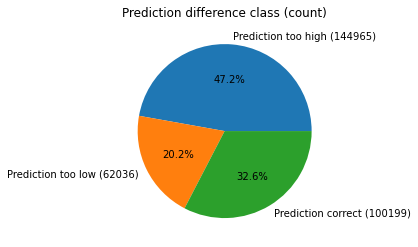

In [15]:
prediction_higher_than_target = np.count_nonzero(all_preds > all_targs)
prediction_lower_than_target = np.count_nonzero(all_preds < all_targs)
prediction_equal_to_target = np.count_nonzero(all_preds == all_targs)
labels = [
    f"Prediction too high ({prediction_higher_than_target})",
    f"Prediction too low ({prediction_lower_than_target})",
    f"Prediction correct ({prediction_equal_to_target})",
]

plt.pie(
    [
        prediction_higher_than_target,
        prediction_lower_than_target,
        prediction_equal_to_target,
    ],
    labels=labels,
    autopct="%1.1f%%",
)
plt.title("Prediction difference class (count)")
plt.show()

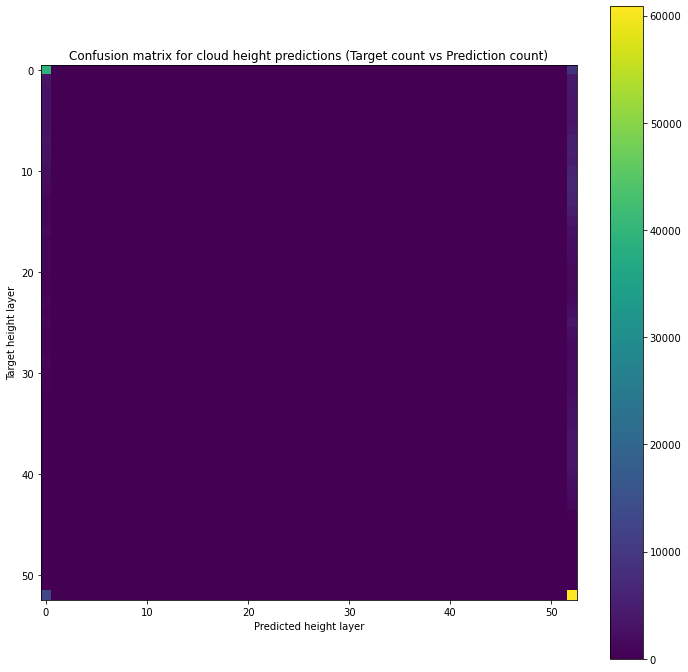


Model predictions binned: (Class label, Count): ((0.0, 101368), (69.0, 205832)) 

Target labels binned: (Class label, Count): ((0.0, 48207), (1.0, 7345), (2.0, 6824), (3.0, 6581), (4.0, 6311), (5.0, 5855), (6.0, 6811), (7.0, 8105), (8.0, 8406), (9.0, 7745), (10.0, 8055), (11.0, 8211), (12.0, 7782), (13.0, 7082), (14.0, 5604), (15.0, 4535), (16.0, 4367), (17.0, 3159), (18.0, 2949), (19.0, 2475), (20.0, 2263), (21.0, 2132), (22.0, 2052), (23.0, 2493), (24.0, 3018), (25.0, 4325), (26.0, 3172), (27.0, 2532), (28.0, 2182), (29.0, 2454), (30.0, 2408), (31.0, 2293), (32.0, 2251), (33.0, 2644), (34.0, 3003), (35.0, 3200), (36.0, 3398), (37.0, 3574), (38.0, 3818), (39.0, 3882), (40.0, 2967), (41.0, 2353), (42.0, 1856), (43.0, 1379), (44.0, 686), (45.0, 233), (46.0, 212), (47.0, 50), (48.0, 12), (49.0, 4), (50.0, 4), (51.0, 4), (69.0, 73937))


In [16]:
# sedi like a,b,d,c mean confusion matrix

plt.figure(figsize=(12, 12))

confm = confusion_matrix(all_targs, all_preds)
plt.imshow(confm, cmap=plt.cm.viridis, interpolation="nearest")
plt.colorbar()
plt.title(
    "Confusion matrix for cloud height predictions (Target count vs Prediction count)"
)
plt.ylabel("Target height layer")
plt.xlabel("Predicted height layer")
plt.show()

labels, counts = np.unique(all_preds, return_counts=True)
bins_pred = tuple(zip(list(labels), list(counts)))
labels, counts = np.unique(all_targs, return_counts=True)
bins_targ = tuple(zip(list(labels), list(counts)))
print("\nModel predictions binned: (Class label, Count):", bins_pred, "\n")
print("Target labels binned: (Class label, Count):", bins_targ)

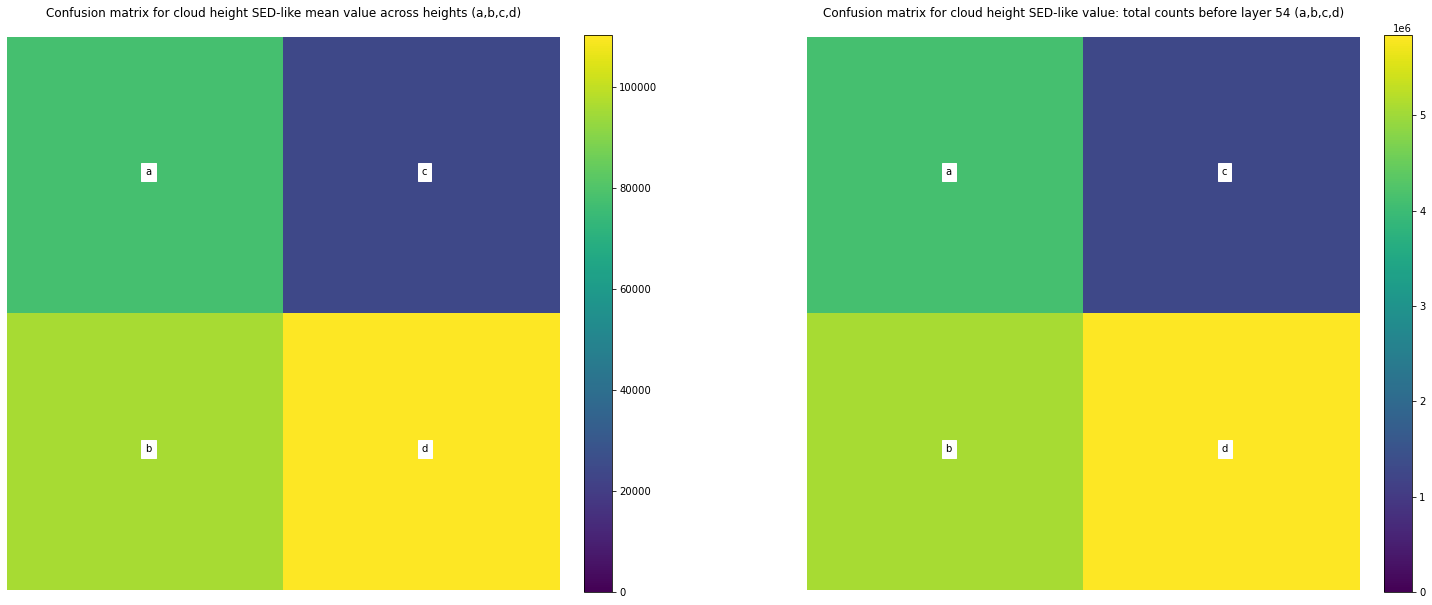

In [17]:
sed_like_conf_matrix = np.reshape(np.mean(np.array(abcd_list).T, axis=1), (2, 2))
labels = ["a", "b", "c", "d"]
fig = plt.figure(figsize=(20, 24))

from matplotlib import colors

divnorm = colors.Normalize(vmin=0.0)
divnorm2 = colors.Normalize(vmin=0.0)

ax1 = fig.add_subplot(121)
im = ax1.imshow(
    sed_like_conf_matrix, cmap=plt.cm.viridis, interpolation="nearest", norm=divnorm
)
for i, lab in enumerate(labels):
    ax1.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im, fraction=0.046, pad=0.04)
ax1.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like mean value across heights (a,b,c,d)",
    pad=20,
)


sed_like_conf_matrix_counts = np.reshape(
    np.sum(np.array(abcd_list[0:54]).T, axis=1), (2, 2)
)
ax2 = fig.add_subplot(122)
im2 = ax2.imshow(
    sed_like_conf_matrix_counts,
    cmap=plt.cm.viridis,
    interpolation="nearest",
    norm=divnorm2,
)
for i, lab in enumerate(labels):
    ax2.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im2, fraction=0.046, pad=0.04)
ax2.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like value: total counts before layer 54 (a,b,c,d)",
    pad=20,
)
plt.tight_layout(w_pad=15)

plt.show()

In [18]:
# plots relating to how the training went
# possible: plots fit to map data